# PHYS 7730 (Data Science) Problem Set Summary
By Kaixin Wang and Prof. Michael Vershinin

## Question 1: Speed
Perform a pseudoinverse with SVD or QR decomposition.\
For the mathematic background of those,
- [Textbook: *Introduction to Linear Algebra, Glibert Strang*](https://math.mit.edu/~gs/linearalgebra/)
- [Video: *pseudoinverse*](https://www.youtube.com/watch?v=Go2aLo7ZOlU&t=6s)
- [Video: *SVD sigular value decomposition*](https://www.youtube.com/watch?v=rYz83XPxiZo)
- [Video: *QR decomposition (Gram-Schmidt)*](https://www.youtube.com/watch?v=0MtwqhIwdrI)

In [10]:
import numpy as np
from numpy import linalg as LAn
from scipy import linalg as LAs
from numpy import matrix as M
import scipy.linalg.lapack as lpk
import time

#Let's restrict ourselves to just real matrices
#This approach is for square non-degenerate matrices
m1=np.random.random((2048,2048))

#Let's start with the naive approach
#Do QR factorization using numpy's QR
#Then brute force the solution
#by inverting both R and Q
t = time.time()
#here we perform the QR decomposition
q, R = LAn.qr(m1)
#Now we construct the inverse
m1a=np.dot(LAn.inv(R),LAn.inv(q))
print('Time elapsed [sec] : ' , time.time() - t)

#That's slow. But R is an upper triangular matrix
#We should be able to use this to speed up the inverse
#If we dig into Lapack documentation, we indeed see
#special subroutines for triangular matrices: strtri and dtrtri
#Since our data is double precision, let's use dtrtri
#Everythiong else is the same, just bypassing python and
#using Blas calls almost diredctly (minimal wrapper)
t = time.time()
#here we perform the QR decomposition
q, R = LAn.qr(m1)
#Now we construct the inverse 
m1b=np.dot(lpk.dtrtri(R)[0],LAn.inv(q))
print('Time elapsed [sec] : ' , time.time() - t)

#A bit better but not much. Maybe inverting R is not the
#rate limiting step. Ah! Q is orthogonal so it's inverse
#is also its transpose. Flipping a matrix is much faster.
#Let's try this...
t = time.time()
#here we perform the QR decomposition
q, R = LAn.qr(m1)
#Now we construct the inverse 
m1c=np.dot(lpk.dtrtri(R)[0],np.transpose(q))
print('Time elapsed [sec] : ' , time.time() - t)

#Now this made a difference. Now maybe we can make it faster
#by doing the multiplication and transpose in the Blas call
#rather than via python. The Blas routine in question is dgemm.
#You can try it but you will have to work hard and play extra
#tricks to get any time improvement and most attempts will be slower.
#Numpy's dot is pretty efficient.

#The Blas (basic linear algebra) and Lapack package is in
#Fortran/C++ evn. For the normal calcultion in python, it is not
#a big deal.


#So the other thing we can try is to use a different QR routine
#For example, on my machine numpy's Blas calls go to openBlas
#but scipy calls go to MKL Blas. The latter should be faster...
t = time.time()
#here we perform the QR decomposition
q, R = LAs.qr(m1)
#Now we construct the inverse 
m1d=np.dot(lpk.dtrtri(R)[0],np.transpose(q))
print('Time elapsed [sec] : ' , time.time() - t)

#Not bad. 

Time elapsed [sec] :  1.609309196472168
Time elapsed [sec] :  1.35636305809021
Time elapsed [sec] :  1.147378921508789
Time elapsed [sec] :  1.1244900226593018


In [11]:
import numpy as np
from numpy import linalg as LAn
from scipy import linalg as LAsqr
from numpy import matrix as M
import scipy.linalg.lapack as lpk
import time

#The previous code was for square matrices
#Here we work with overdetermined systems
#Let's pick a non-square case but still 
#more or less square so size is easy to discuss
m1=np.random.random((2048,2047))

#We start with transposing Q and 
#using the fast QR routine in scipy Blas
t = time.time()
#here we perform the QR decomposition
q, R = LAs.qr(m1,mode='economic')
#Now we construct the inverse 
#Now we cannot even start with trying 
#to invert the matrices directly
#so tranpose it is
m1a=np.dot(LAn.inv(R),np.transpose(q))
print('Time elapsed [sec] : ' , time.time() - t)

#The best, again, is to also use dtrtri to invert R
t = time.time()
#here we perform the QR decomposition
q, R = LAs.qr(m1,mode='economic')
#Now we construct the inverse 
m1b=np.dot(lpk.dtrtri(R)[0],np.transpose(q))
print('Time elapsed [sec] : ' , time.time() - t)

Time elapsed [sec] :  1.1000728607177734
Time elapsed [sec] :  0.9728789329528809


In [12]:
#Great. So now we are on to SVD implementation
import numpy as np
from numpy import linalg as LAn
from scipy import linalg as LAs
from numpy import matrix as M
import scipy.linalg.lapack as lpk
import time

#Let's restrict ourselves to just real matrices
#This approach is for square non-degenerate matrices
m1=np.random.random((2048,2048))

#Let's start with the naive approach
#Do SVD factorization using numpy's SVD
#Then brute force the solution for inverse
t = time.time()
#here we perform the SVD decomposition
u,s,vh = LAn.svd(m1)
#We need S inverse
#Considering this is a double precision float
#the singular values should be much above
#the critical spacing of the data type
tinySV = s<100*np.finfo(np.float64).eps  #return a boolean array
#Any tiny singular value gets set to zero
s[tinySV]=0
#All other singular values get inverted
s[~tinySV]=np.reciprocal(s[~tinySV])  #tilde iterate all the list and apply 'not' each
#Now we construct the inverse
m1a=np.dot(LAn.inv(vh),np.dot(np.diag(s),LAn.inv(u)))
print('Time elapsed [sec] : ' , time.time() - t)

#Let's get rid of inverses for vh and u since
#these are both unitary and for real matrices this 
#means they orthogonal, so we just need to tranpose
#to get their inverse
#We do SVD factorization using numpy's SVD
t = time.time()
#here we perform the SVD decomposition
u,s,vh = LAn.svd(m1)
#We need S inverse (single array instead a matrix)
#Considering this is a double precision float
#the singular values should be much above
#the critical spacing of the data type
tinySV = s<100*np.finfo(np.float64).eps  #return a boolean array
#Any tiny singular value gets set to zero
s[tinySV]=0
#All other singular values get inverted
s[~tinySV]=np.reciprocal(s[~tinySV])  #tilde iterate all the list and apply 'not' each
#Now we construct the inverse the new way
m1a=np.dot(np.transpose(vh),np.dot(np.diag(s),np.transpose(u)))
print('Time elapsed [sec] : ' , time.time() - t)

#So the other thing we can try is to use a different SVD routine
#For example, on my machine numpy's Blas calls go to openBlas
#but scipy calls go to MKL Blas. The latter should be faster...
t = time.time()
#here we perform the SVD decomposition
u,s,vh = LAs.svd(m1)
#We need S inverse
#Considering this is a double precision float
#the singular values should be much above
#the critical spacing of the data type
tinySV = s<100*np.finfo(np.float64).eps
#Any tiny singular value gets set to zero
s[tinySV]=0
#All other singular values get inverted
s[~tinySV]=np.reciprocal(s[~tinySV])
#Now we construct the inverse the new way
m1b=np.dot(np.transpose(vh),np.dot(np.diag(s),np.transpose(u)))
print('Time elapsed [sec] : ' , time.time() - t)

#Not bad. In the end, it is mostly about getting SVD to run fast

Time elapsed [sec] :  5.2106852531433105
Time elapsed [sec] :  3.400459051132202
Time elapsed [sec] :  2.8234758377075195


In [16]:
#Finally let's see this run for an overdetermined system
import numpy as np
from numpy import linalg as LAn
from scipy import linalg as LAs
from numpy import matrix as M
import scipy.linalg.lapack as lpk
import time

#Let's restrict ourselves to just real matrices
#This approach is for non-square non-degenerate matrices
m1=np.random.random((2048,2047))

#Let's start with the naive approach
#Do SVD factorization using numpy's SVD
#Then brute force the solution for inverse
t = time.time()
#here we perform the SVD decomposition
#Notice that for non-square matrices we again
#want to use "economy" version of SVD, much like
#we did for QR - to save some time
u,s,vh = LAn.svd(m1,full_matrices=False)
#We need S inverse
#Considering this is a double precision float
#the singular values should be much above
#the critical spacing of the data type
tinySV = s<100*np.finfo(np.float64).eps
#Any tiny singular value gets set to zero
s[tinySV]=0
#All other singular values get inverted
s[~tinySV]=np.reciprocal(s[~tinySV])
#Now we construct the inverse
#Let's just cut to the chanse and do tranposes here
#because inverses at this step will not work for 
#non-square matrix we started with
m1a=np.dot(np.transpose(vh),np.dot(np.diag(s),np.transpose(u)))
print('Time elapsed [sec] : ' , time.time() - t)

#I will also now use the faster SVD from my scipy's MKL
t = time.time()
#here we perform the SVD decomposition
#Notice that for non-square matrices we again
#want to use "economy" version of SVD, much like
#we did for QR - to save some time
u,s,vh = LAs.svd(m1,full_matrices=False)
#We need S inverse
#Considering this is a double precision float
#the singular values should be much above
#the critical spacing of the data type
tinySV = s<100*np.finfo(np.float64).eps
#Any tiny singular value gets set to zero
s[tinySV]=0
#All other singular values get inverted
s[~tinySV]=np.reciprocal(s[~tinySV])
#Now we construct the inverse
#Let's just cut to the chanse and do tranposes here
#because inverses at this step will not work for 
#non-square matrix we started with
m1a=np.dot(np.transpose(vh),np.dot(np.diag(s),np.transpose(u)))
print('Time elapsed [sec] : ' , time.time() - t)

#Let's try to use SVD via a direct Blas dgesvd call
t = time.time()
#here we perform the SVD decomposition
#Notice that for non-square matrices we again
#want to use "economy" version of SVD, much like
#we did for QR - to save some time
u,s,vh, info = lpk.dgesvd(m1,full_matrices=False)
#We need S inverse
#Considering this is a double precision float
#the singular values should be much above
#the critical spacing of the data type
tinySV = s<100*np.finfo(np.float64).eps
#Any tiny singular value gets set to zero
s[tinySV]=0
#All other singular values get inverted
s[~tinySV]=np.reciprocal(s[~tinySV])
#Now we construct the inverse
#Let's just cut to the chanse and do tranposes here
#because inverses at this step will not work for 
#non-square matrix we started with
m1a=np.dot(np.transpose(vh),np.dot(np.diag(s),np.transpose(u)))
print('Time elapsed [sec] : ' , time.time() - t)

#What???? dgesvd is much slower?!?!?!
#Yes indeed. This is because python chose to use dgesdd rather than dgesvd
#Tradeoff: dgesdd is much faster but it fails to converge sometimes
#Tradeoff: dgesvd is slower but it does not fail to converge

#Fine! Let's play with fire and go along with python's default choice
#Let's try to use SVD via a dgesdd call
t = time.time()
#here we perform the SVD decomposition
#Notice that for non-square matrices we again
#want to use "economy" version of SVD, much like
#we did for QR - to save some time
u,s,vh, info = lpk.dgesdd(m1,full_matrices=False)
#We need S inverse
#Considering this is a double precision float
#the singular values should be much above
#the critical spacing of the data type
tinySV = s<100*np.finfo(np.float64).eps
#Any tiny singular value gets set to zero
s[tinySV]=0
#All other singular values get inverted
s[~tinySV]=np.reciprocal(s[~tinySV])
#Now we construct the inverse
#Let's just cut to the chanse and do tranposes here
#because inverses at this step will not work for 
#non-square matrix we started with
m1a=np.dot(np.transpose(vh),np.dot(np.diag(s),np.transpose(u)))
print('Time elapsed [sec] : ' , time.time() - t)

#Not bad. In the end, it is mostly about getting SVD to run fast
#We could maybe speed it up a bit more if we played games to reduce
#overhead involved with calling svd functions of blas directly
#this usually involves worrying about row vs column order for 
#matrix layout in memory

Time elapsed [sec] :  4.865624189376831
Time elapsed [sec] :  3.171349048614502
Time elapsed [sec] :  36.85786294937134
Time elapsed [sec] :  3.1450870037078857


The matrix size is  (2.0, 1.0)
--------------------------------------------------
The matrix size is  (4.0, 3.0)
--------------------------------------------------
The matrix size is  (8.0, 7.0)
--------------------------------------------------
The matrix size is  (16.0, 15.0)
--------------------------------------------------
The matrix size is  (32.0, 31.0)
--------------------------------------------------
The matrix size is  (64.0, 63.0)
--------------------------------------------------
The matrix size is  (128.0, 127.0)
--------------------------------------------------
The matrix size is  (256.0, 255.0)
--------------------------------------------------
The matrix size is  (512.0, 511.0)
--------------------------------------------------
The matrix size is  (1024.0, 1023.0)
--------------------------------------------------
The matrix size is  (2048.0, 2047.0)
--------------------------------------------------


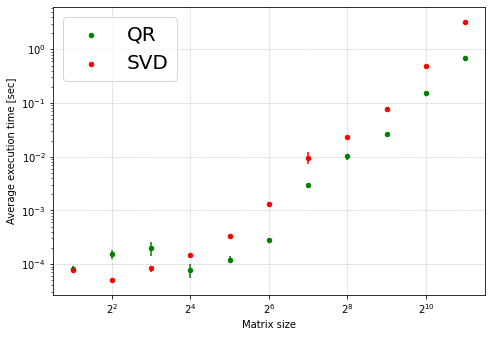

In [32]:
#Now that we have some faster implementations, 
#let's benchmark QR vs SVD
#Finally let's see this run for an overdetermined system
import numpy as np
from numpy import linalg as LAn
from scipy import linalg as LAs
from numpy import matrix as M
import scipy.linalg.lapack as lpk
import time

#vec contains powers (of 2) for matrix sizes
vec=np.linspace(1,11,11)
#Initialize output variables
meanQR=np.zeros((vec.size,1))
stdQR=np.zeros((vec.size,1))
meanSVD=np.zeros((vec.size,1))
stdSVD=np.zeros((vec.size,1))
#total number of repetation is "nrep"
nrep = 20

for ii in vec:
    #We will use matrix sizes which are powers of 2
    m1=np.random.random((int(np.power(2.0,ii)),int(np.power(2.0,ii)-1)));

    def myQR():
        #here we perform the QR decomposition
        q, R = LAs.qr(m1,mode='economic')
        #Now we construct the inverse 
        m1b=np.dot(lpk.dtrtri(R)[0],np.transpose(q))

    def mySVD():
        #here we perform the SVD decomposition
        #Notice that for non-square matrices we again
        #want to use "economy" version of SVD, much like
        #we did for QR - to save some time
        u,s,vh = LAs.svd(m1,full_matrices=False)
        #We need S inverse
        #Considering this is a double precision float
        #the singular values should be much above
        #the critical spacing of the data type
        tinySV = s<100*np.finfo(np.float64).eps
        #Any tiny singular value gets set to zero
        s[tinySV]=0
        #All other singular values get inverted
        s[~tinySV]=np.reciprocal(s[~tinySV])
        #Now we construct the inverse
        #Let's just cut to the chanse and do tranposes here
        #because inverses at this step will not work for 
        #non-square matrix we started with
        m1a=np.dot(np.transpose(vh),np.dot(np.diag(s),np.transpose(u)))

    print('The matrix size is ', (np.power(2.0,ii),np.power(2.0,ii)-1))   
    Tqr=np.zeros((nrep,1)); Tsvd=np.zeros((nrep,1))
    #Here we run QR code a bunch of times and get some statistics
    for jj in np.linspace(0,nrep-1,nrep).astype(int):
         t = time.time(); myQR(); Tqr[jj] = time.time()-t
    meanQR[int(ii-1)]=np.mean(Tqr); stdQR[int(ii-1)]=np.std(Tqr)
    #Here we run SVD code a bunch of times and get some statistics
    for jj in np.linspace(0,nrep-1,nrep).astype(int):
         t = time.time(); mySVD(); Tsvd[jj] = time.time()-t
    meanSVD[int(ii-1)]=np.mean(Tsvd); stdSVD[int(ii-1)]=np.std(Tsvd)
    print('--------------------------------------------------')

### Plot ###
import matplotlib.pyplot as plt
#Set up the plot
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
#Define x axis values as matrix size
xaxis=np.power(2,vec)
#Define y axis error bar sizes for QR data
errQR=stdQR/np.sqrt(nrep)
#Define y axis error bar sizes for SVD data
errSVD=stdSVD/np.sqrt(nrep)
#We want scatter plot for both data sets
#QR data is in green
plt.scatter(xaxis,meanQR,c='green',s=20,label='QR') 
plt.errorbar(xaxis,meanQR.ravel(), yerr = errQR.ravel(), fmt='.', color='green')
#SVD data is in red
plt.scatter(xaxis,meanSVD,c='red',s=20,label='SVD') 
plt.errorbar(xaxis,meanSVD.ravel(), yerr = errSVD.ravel(), fmt='.', color='red')
#The numpy.ravel() functions returns contiguous flattened array
#(1D array with all the input-array elements and with the same type as it)

#Finish up plot definition
plt.xlabel('Matrix size')
plt.ylabel('Average execution time [sec]')
plt.grid(color='gray', linestyle='dotted', linewidth=.5)
plt.grid(visible=True)
#It is easiest to see the trend on a log-log plot
ax.set_yscale('log')
ax.set_xscale('log',base=2)
#Finally we show user the legend
plt.legend(fontsize=20)
plt.show()